In [1]:
# GPU scaling lidDrivenCavity
# comparison OF + DIC vs GKO and var. preconditioner
import matplotlib.pyplot as plt
import numpy as np
from import_benchmark_data import import_results
from plot_funcs import line_plot, ogl_plot
from helpers import idx_query, idx_keep_only, compute_speedup, calc_nodes, merge_index
import pandas as pd
from pathlib import Path

plt.rcParams.update({'font.size': 16})

No Salvia installation found
Owls Version: 0.10.0-26-g31283c0
Warning no matplotlib support


In [2]:
def write_figure_readme(path, fn, args):
    md_fn = fn.replace("png", "md")
    with open(path / md_fn, "w") as md_fh:
        md_fh.write("# {}\n".format(args["case"]))
        md_fh.write("![figure]({})\n".format(fn))
        md_fh.write("| machine name | {} |\n".format(args["nodes"]))
        md_fh.write("| case | {} |\n".format(args["case"]))
        md_fh.write("| ranks | {} |\n".format(args["ranks"]))

In [6]:
def ogl_plot(
    df, x, ys, x_label, idxs, facets, host, 
    case, speedup_base=None, y_labels=[], 
    drop_base=True, facet_is_legend="final", add_to_fn="",
    campaign=""):
    drop_indices = ["node", "mpiRank_of", "processes", "omp_threads", "mpiRank_gko", "executor_p", "mpi_ranks"]
    ignore_indices = []
    if speedup_base:
        for idx, val in speedup_base:
            if idx in drop_indices:
                drop_indices.remove(idx)
    if x in drop_indices:
        drop_indices.remove(x)
    if facets[0] in drop_indices:
        drop_indices.remove(facets[0])
        ignore_indices.append(facets[0])
    df = df.drop(["log_id", "timestamp" , "case"] ,axis=1)
    y_labels = y_labels if y_labels else ys
    facet = facets[0]
    other_facet = facets[1] if len(facets) == 2 else ""
    if other_facet:
        lines = set(df.index.get_level_values(other_facet))
        dfs = [idx_query(df, [(facets[1], val, True)]) for val in lines]
    else:
        dfs = [df]
        lines=[False]
        
    for y, y_label in zip(ys, y_labels):
        columns = [y]
        fig, axes = plt.subplots(1,
                len(columns),
                figsize=(7 * len(columns), 7),
                sharex=False,
                sharey=False,
                gridspec_kw={'wspace': 0.5},
                subplot_kw={'frameon': True})
        axes = [axes]
        for (df_, add_to_legend, ls) in zip(dfs, lines, ["-", "--", "-."]):
            add_to_legend = str(add_to_legend) if add_to_legend else False
                
            df_filt = idx_query(df_, idxs)
            # get properties for props file
            nodes = set(df_filt.index.get_level_values("node"))
            mpi_ranks = set(df_filt.index.get_level_values("mpi_ranks"))
            args = {"nodes": nodes, "case": case, "ranks": mpi_ranks}
            
            if speedup_base:
                sel = compute_speedup(df_filt, speedup_base,
                    drop_indices=drop_indices,
                    ignore_indices=ignore_indices                  
                    ).sort_index()
                if drop_base:
                    sel = idx_query(sel, [(speedup_base[0][0],speedup_base[0][1], False)])
            else:
                sel = df_filt.sort_index()
                
            line_plot(sel[y], 
                x=x, 
                columns=columns, 
                facet=facet,
                fig=fig,
                axes=axes,
                facet_is_legend=facet_is_legend,
                add_to_legend=add_to_legend,
                properties={
                #"legends": ["2", "3", "4"],
                "linestyle": lambda x: ls,
                "marker": lambda x: "P",
                "title": lambda x: ["Linear Solve P"][x]
           })

        for ax in axes:
                ax.grid(True, axis='x', which="both", alpha=0.2)
                ax.grid(True, axis='y', which="both", alpha=0.2)
                ax.grid(True, axis="y", which="minor", alpha=0.2)
                ax.set_xlabel(x_label)
        y_label = "Speed up '{}' [-]".format(y) if speedup_base else y_label
        axes[0].set_ylabel(y_label)
        y = y_label.replace(" ", "_").replace("[-]","").replace("'","").replace("/", "_by_")
        if speedup_base:
            y+= "_over_" + str(speedup_base[0][1])
        fn = host + "_" + campaign +"_" + y + "_by_" + facet + "_rev_" + other_facet + "_" + revision + "_" + add_to_fn + ".png"
        fn = fn.replace("__","_")
        print("save ", fn)
        write_figure_readme(path, fn, args)
        plt.savefig(path /fn, bbox_inches='tight')

In [4]:
# load dfs 

revision = "a1aee2e4"
campaign = "repartition"
case = "lidDrivenCavity"
path_case = "../../results/{}/{}/".format(campaign, revision)
path = Path("../../results/{}/".format(campaign))

df = import_results(
    path=path_case,
    case=case,        
    short_hostname_map={
        "nla": "nla",
        "hkn": "horeka"
    },
    filt="single",
    transform_resolution=False
    )["raw"]

TypeError: import_results() missing 2 required positional arguments: 'campaign' and 'revision'

save  Speed_up_linear_solve_p__linear_solve_p_by_matrixFormat_rev_a1aee2e4.png


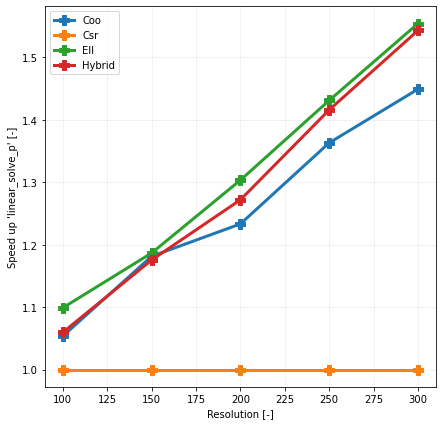

In [72]:
ogl_plot(
    df,
    ys=["linear_solve_p"],
    x="resolution",
    x_label = "Resolution [-]",
    idxs = [
        ("solver_p", "CG"),
        ("node", "nla", True),
        ("resolution", 350, False),
        ("resolution", 400, False),
        ],
    facet = "matrixFormat",
    speedup_base = [("matrixFormat", "Csr")])

In [22]:
df.sort_index()

timestamp  \
solver_p executor_p preconditioner_p resolution omp_threads mpi_ranks node backend_p processes mpiRank_gko mpiRank_of cells     dofs_per_rank                               
CG       HIP        NoPrecond        100        None        8         nla  Ginkgo    1         1.0         0.0        1000000   125000.00      2022-10-24 06:42:47.929456   
                                                            16        nla  Ginkgo    1         2.0         0.0        1000000   62500.00       2022-11-02 10:41:03.002478   
                                                            32        nla  Ginkgo    1         4.0         0.0        1000000   31250.00       2022-11-02 11:45:04.086553   
                                     150        None        8         nla  Ginkgo    1         1.0         0.0        3375000   421875.00      2022-10-24 06:43:25.245714   
                                                            16        nla  Ginkgo    1         2.0         0.0        3375000   210937.50      2022-11-02 10:41:38.675027   
                                                            32        nla  Ginkgo    1         4.0         0.0        3375000   105468.75      2022-11-02 11:45:45.783178   
                                     200        None        8         nla  Ginkgo    1         1.0         0.0        8000000   1000000.00     2022-10-24 06:44:42.782988   
                                                            16        nla  Ginkgo    1         2.0         0.0        8000000   500000.00      2022-11-02 10:42:48.310297   
                                                            32        nla  Ginkgo    1         4.0         0.0        8000000   250000.00      2022-11-02 11:46:59.801327   
                                     250        None        8         nla  Ginkgo    1         1.0         0.0        15625000  1953125.00     2022-10-24 06:47:07.279902   
                                                            16        nla  Ginkgo    1         2.0         0.0        15625000  976562.50      2022-11-02 10:44:55.645795   
                                                            32        nla  Ginkgo    1         4.0         0.0        15625000  488281.25      2022-11-02 11:49:16.845240   
                                     300        None        8         nla  Ginkgo    1         1.0         0.0        27000000  3375000.00     2022-10-24 06:51:39.251160   
                                                            16        nla  Ginkgo    1         2.0         0.0        27000000  1687500.00     2022-11-02 10:48:54.625009   
                                                            32        nla  Ginkgo    1         4.0         0.0        27000000  843750.00      2022-11-02 11:53:01.902083   
                                     350        None        8         nla  Ginkgo    1         1.0         0.0        42875000  5359375.00     2022-10-24 06:59:41.211915   
                                                            16        nla  Ginkgo    1         2.0         0.0        42875000  2679687.50     2022-11-02 10:54:48.688161   
                                                            32        nla  Ginkgo    1         4.0         0.0        42875000  1339843.75     2022-11-02 11:59:42.836422   
                                     400        None        8         nla  Ginkgo    1         1.0         0.0        64000000  8000000.00     2022-10-24 07:12:16.288581   
                                                            16        nla  Ginkgo    1         2.0         0.0        64000000  4000000.00     2022-11-02 11:04:33.863738   
                                                            32        nla  Ginkgo    1         4.0         0.0        64000000  2000000.00     2022-11-02 12:10:49.014115   
                                     450        None        16        nla  Ginkgo    1         2.0         0.0        91125000  5695312.50     2022-11-02 11:20:26.663317   
        

importing Logs ../../results/multi_gpu/3698b09e/lidDrivenCavity/repartitioned_update/Logs
parse_log_strings list index out of range
parse_log_strings list index out of range
parse_log_strings list index out of range
parse_log_strings list index out of range
parse_log_strings list index out of range
parse_log_strings list index out of range
parse_log_strings list index out of range
parse_log_strings list index out of range
parse_log_strings list index out of range
parse_log_strings list index out of range
parse_log_strings list index out of range
parse_log_strings list index out of range
parse_log_strings list index out of range
parse_log_strings list index out of range
parse_log_strings list index out of range
parse_log_strings list index out of range
parse_log_strings list index out of range
parse_log_strings list index out of range
parse_log_strings list index out of range
parse_log_strings list index out of range
parse_log_strings list index out of range
parse_log_strings list index

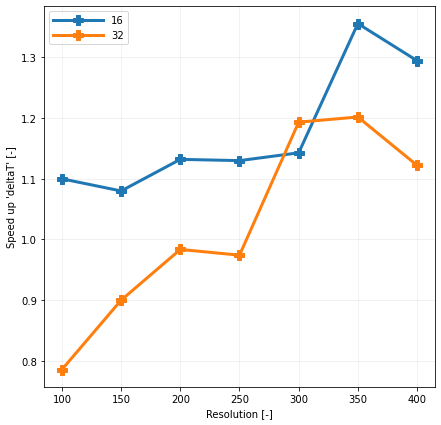

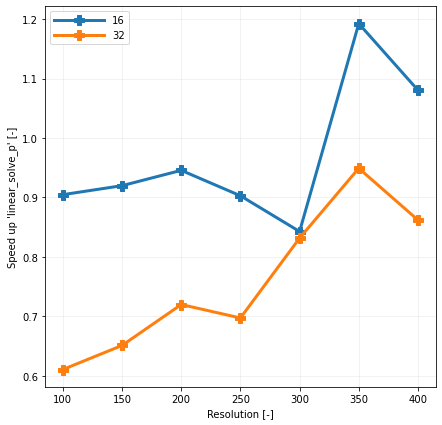

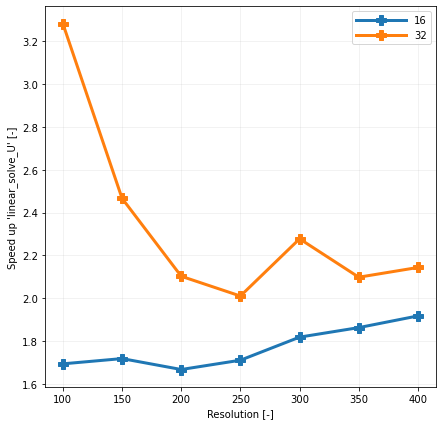

In [4]:
# load dfs
revision = "3698b09e"
branch = "multi_gpu"
case = "lidDrivenCavity"
campaign = "repartitioned_update"

path_case = "../../results/{}/".format(branch)
path = Path("../../results/{}/".format(branch))

df = idx_query(
    import_results(
        path=path_case,
        case=case,
        campaign=campaign,
        revision=revision,
        short_hostname_map={
            "nla": "nla",
            "hkn": "horeka",
        },
        filt="matrix_format",
        transform_resolution=False
    )["raw"],
    [
        ("solver_p", "CG"),
        ("node", "nla", True),
        ("backend_p", "Ginkgo", True),
        #("resolution", 450, False),
        #("resolution", 400, False),
        ("mpi_ranks", 2, False),
        ("mpi_ranks", 4, False),
        ("mpi_ranks", 6, False)
    ])

ogl_plot(
    df,
    path=path,
    ys=["deltaT", "linear_solve_p", "linear_solve_U"],
    x="resolution",
    x_label = "Resolution [-]",
    idxs = [],
    host="nla",
    case=case,
    revision=revision,
    campaign=campaign,
    facets = ["mpi_ranks"],
    speedup_base = [("mpi_ranks", 8)])

In [8]:
df_gko = idx_query(df, [
        ("backend_p", "Ginkgo"),
        ("mpi_ranks", 8),
        ])

df_gko

timestamp  \
solver_p executor_p preconditioner_p resolution omp_threads mpi_ranks node processes mpiRank_gko backend_p mpiRank_of                               
CG       HIP        NoPrecond        350        None        8         nla  1         1.0         Ginkgo    0.0         2022-09-27 16:10:26.116111   
                                     100        None        8         nla  1         1.0         Ginkgo    0.0         2022-09-27 15:20:01.359118   
                                     400        None        8         nla  1         1.0         Ginkgo    0.0         2022-09-27 17:05:16.773155   
                                     150        None        8         nla  1         1.0         Ginkgo    0.0         2022-09-27 19:16:16.553724   
                                     200        None        8         nla  1         1.0         Ginkgo    0.0         2022-09-27 15:22:58.260325   
                                     250        None        8         nla  1         1.0         Ginkgo    0.0         2022-09-27 19:22:25.780518   
                                     300        None        8         nla  1         1.0         Ginkgo    0.0         2022-09-27 15:36:27.430198   

                                                                                                                                                 log_id  \
solver_p executor_p preconditioner_p resolution omp_threads mpi_ranks node processes mpiRank_gko backend_p mpiRank_of                                     
CG       HIP        NoPrecond        350        None        8         nla  1         1.0         Ginkgo    0.0         4f1c24e0c346031ca3924548e08c04ae   
                                     100        None        8         nla  1         1.0         Ginkgo    0.0         a0fa3e42e98777f5d03a2f8813de1596   
                                     400        None        8         nla  1         1.0         Ginkgo    0.0         f64d914f41486917e7c67c927e9bb18f   
                                     150        None        8         nla  1         1.0         Ginkgo    0.0         5921cca92d01e9bdf215f58b01bb45ed   
                                     200        None        8         nla  1         1.0         Ginkgo    0.0         bc3c059ad675a4c6150b39bc266917b3   
                                     250        None        8         nla  1         1.0         Ginkgo    0.0         752371c08c3a01e5861cc832fa2ff38a   
                                     300        None        8         nla  1         1.0         Ginkgo    0.0         353ef9491d09c034ccfc7bb1ed142f70   

                                                                                                                          run_time  \
solver_p executor_p preconditioner_p resolution omp_threads mpi_ranks node processes mpiRank_gko backend_p mpiRank_of                
CG       HIP        NoPrecond        350        None        8         nla  1         1.0         Ginkgo    0.0         1024.079787   
                                     100        None        8         nla  1         1.0         Ginkgo    0.0           16.606758   
                                     400        None        8         nla  1         1.0         Ginkgo    0.0         1685.771647   
                                     150        None        8         nla  1         1.0         Ginkgo    0.0           48.288743   
                                     200        None        8         nla  1         1.0         Ginkgo    0.0          121.676718   
                                     250        None        8         nla  1         1.0         Ginkgo    0.0          254.157617   
                                     300        None        8         nla  1         1.0         Ginkgo    0.0          544.630015   

                                                                                                                       linear_solve_p  \
solver_p executor_p preconditioner_p resolution omp_th

importing Logs ../../results/repartition/a1aee2e4/lidDrivenCavity/Logs
save  Linear_solve_p_[ms]_linear_solve_p_by_mpi_ranks_rev_a1aee2e4.png
save  Linear_solve_U_[ms]_linear_solve_U_by_mpi_ranks_rev_a1aee2e4.png
save  Linear_solve_p_by_U__linear_solve_p_ratio_by_mpi_ranks_rev_a1aee2e4.png


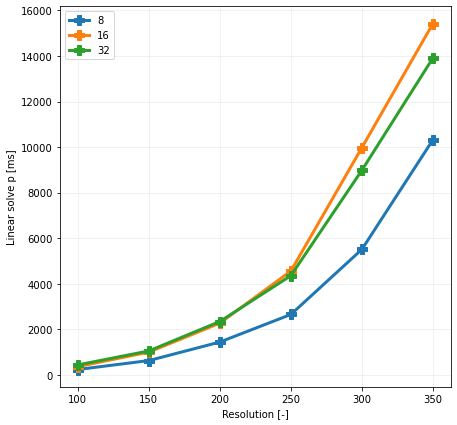

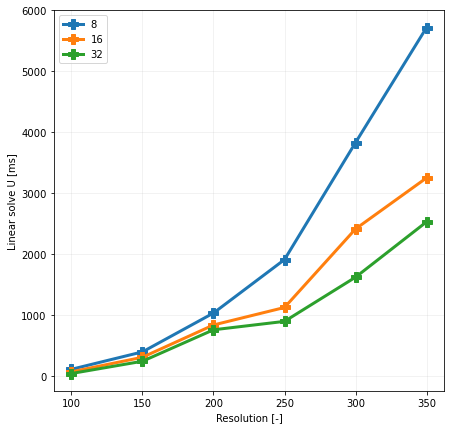

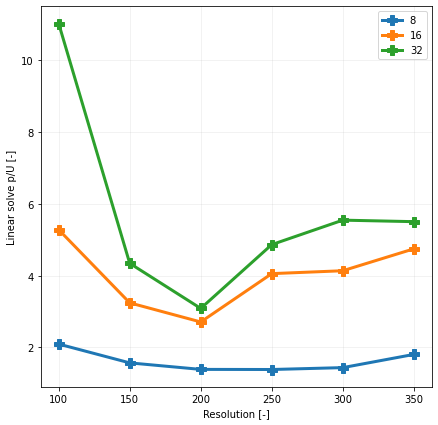

In [100]:
# load dfs 
df = import_results(
    path=path_case,
    case=case,        
    short_hostname_map={
        "nla": "nla",
        "hkn": "horeka"
    },
    filt="matrix_format",
    transform_resolution=False
    )["raw"]

ogl_plot(
    df,
    ys=["linear_solve_p", "linear_solve_U", "linear_solve_p_ratio"],
    y_labels=["Linear solve p [ms]", "Linear solve U [ms]", "Linear solve p/U [-]"],
    x="resolution",
    x_label = "Resolution [-]",
    idxs = [
        ("solver_p", "CG"),
        ("node", "nla", True),
        ("backend_p", "Ginkgo", True),
        #("resolution", 350, False),
        ("resolution", 400, False),
        ],
    facet = "mpi_ranks",
    drop_indices = ["node", "mpiRank_of", "processes", "omp_threads"],
    #speedup_base = [("mpi_ranks", 8)]
)

In [36]:
print (fn)

Speed_up_linear_solve_p__linear_solve_p_by_mpi_ranks_rev_a1aee2e4.png


Breakdown_linear_solve_p_over_mpi_ranks_at_300.png


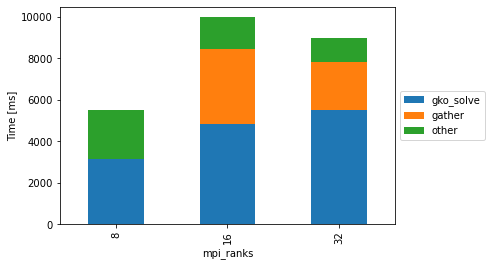

In [38]:
resolution = 300
sel = idx_query(df, 
    [("executor_p", "HIP"),
     ("resolution", resolution)]           
                )
a = ["linear_solve_p"]
c = ['gko_solve', "gather"] 
sel = sel[c + a]
over = "mpi_ranks"
sel = idx_keep_only(sel, [over])

sel["other"] = sel[a]
for i in c:
    sel["other"] = sel["other"] - sel[i]

sel = sel[c + ["other"]]

plot = sel.sort_index().plot.bar(stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plot.set_ylabel("Time [ms]")
fn = "Breakdown_{}_over_{}_at_{}.png".format(a[0],over,resolution)
print(fn)
plt.savefig(path / fn   , bbox_inches='tight')

importing Logs ../../results/distributed-update/010a2918/lidDrivenCavity/single_node/Logs
parse_log_strings list index out of range
popping 6efe069df2367d1e790d2082aa223b65
save  nla_Speed_up_deltaT_over_OF_by_backend_p_rev_010a2918_.png
save  nla_Speed_up_linear_solve_p_over_OF_by_backend_p_rev_010a2918_.png
save  nla_Speed_up_linear_solve_U_over_OF_by_backend_p_rev_010a2918_.png
save  nla_Speed_up_number_iterations_p_over_OF_by_backend_p_rev_010a2918_.png


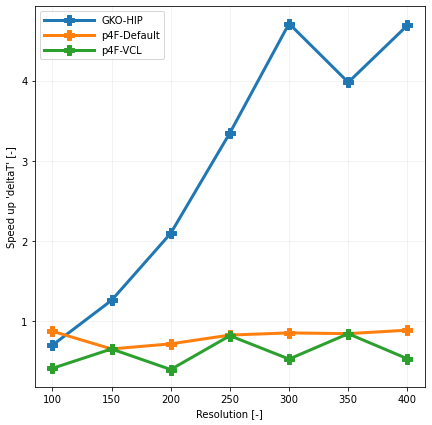

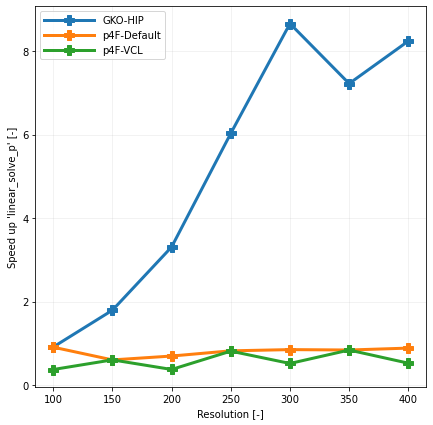

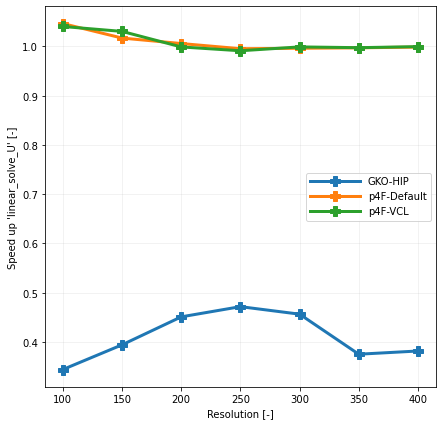

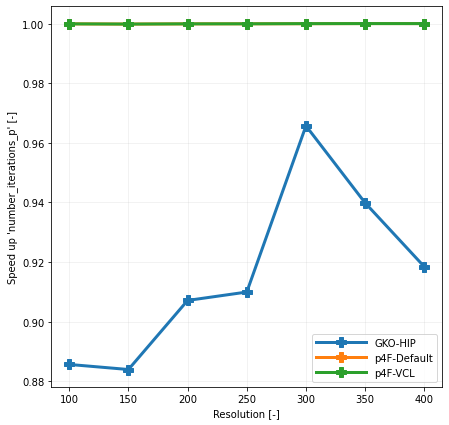

In [96]:
# load dfs
revision = "010a2918"
branch = "distributed-update"
case = "lidDrivenCavity"
campaign = "single_node"

path_case = "../../results/{}/".format(branch)
path = Path("../../results/{}/".format(branch))

df = idx_query(
    import_results(
        path=path_case,
        case=case,
        campaign=campaign,
        revision=revision,
        short_hostname_map={
            "nla": "nla",
            "hkn": "horeka",
        },
        filt="matrix_format",
        transform_resolution=False
    )["raw"],
    [
        ("solver_p", "CG"),
        ("node", "nla", True)
    ])
    
df_gko = idx_query(df, [
        ("backend_p", "Ginkgo"),
        ("mpi_ranks", 8),
        ])
df_petsc = idx_query(df, [("backend_p", "PETSC")])
df_of = idx_query(df, [("backend_p", "OpenFOAM")])
df = pd.concat([df_gko, df_petsc, df_of])

m = {"HIPGinkgo": "GKO-HIP", "HIPPETSC": "p4F-VCL", "DefaultPETSC":"p4F-Default", "DefaultOpenFOAM": "OF"}
df = merge_index(df, "backend_p", "executor_p", m)

ogl_plot(
    df,
    ys=["deltaT", "linear_solve_p", "linear_solve_U", "number_iterations_p"],
    x="resolution",
    x_label = "Resolution [-]",
    idxs = [],
    facets = ["backend_p"],
    host="nla",
    case=case,
    speedup_base = [("backend_p", "OF")])

importing Logs ../../results/distributed-update/1654aacd/lidDrivenCavity/single_node/Logs
parse_log_strings list index out of range
parse_log_strings list index out of range
popping 38138503b9ed2ae5f394f9ba8e965290
popping 531878e4ddc35c42e22925b9c4cfd373
save  Speed_up_deltaT_over_OF_by_backend_p_rev_1654aacd_wo50.png
save  Speed_up_linear_solve_p_over_OF_by_backend_p_rev_1654aacd_wo50.png
save  Speed_up_linear_solve_U_over_OF_by_backend_p_rev_1654aacd_wo50.png
save  Speed_up_number_iterations_p_over_OF_by_backend_p_rev_1654aacd_wo50.png


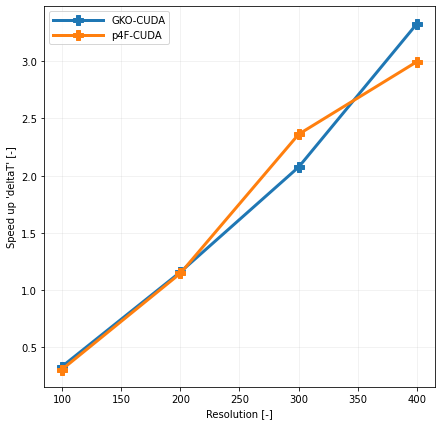

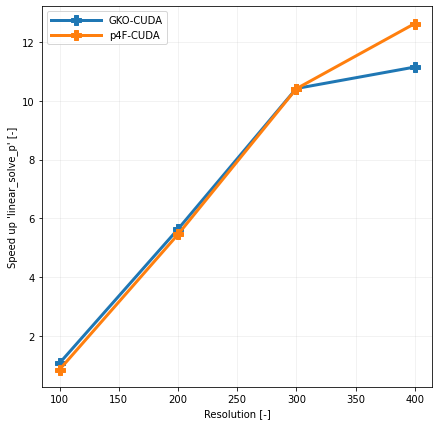

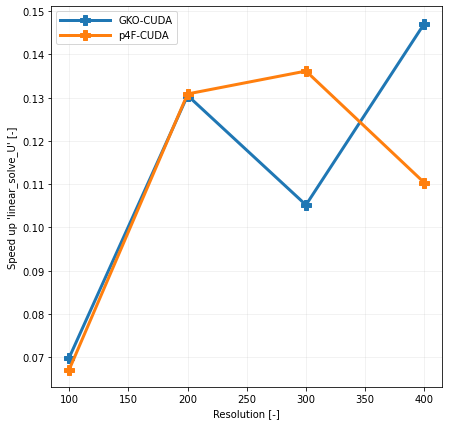

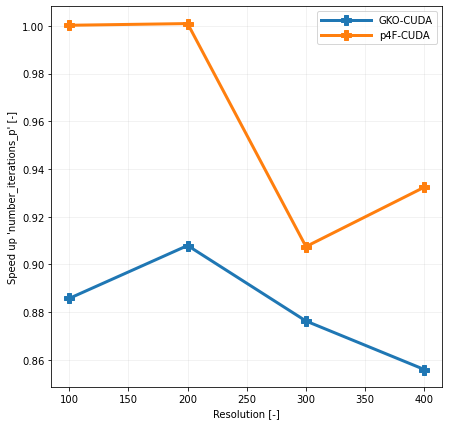

In [93]:
revision = "1654aacd"
branch = "distributed-update"
case = "lidDrivenCavity"
campaign = "single_node"
path_case = "../../results/{}/".format(branch)
path = Path("../../results/{}/".format(branch))

df = idx_query(
    import_results(
        path=path_case,
        case=case,
        campaign=campaign,
        revision=revision,
        short_hostname_map={
            "nla": "nla",
            "hkn": "horeka",
        },
        filt="matrix_format",
        transform_resolution=False
    )["raw"],
    [
        ("solver_p", "CG"),
        ("node", "horeka", True),
        ("resolution", 150, False),
        ("resolution", 250, False),
        ("resolution", 350, False),
    ])

df_gko = idx_query(df, [("backend_p", "Ginkgo"),("mpi_ranks", 4),])
df_petsc = idx_query(df, [("backend_p", "PETSC"),("mpi_ranks", 4),])
df_of = idx_query(df, [("backend_p", "OpenFOAM")])
df = pd.concat([df_gko, df_petsc, df_of])

m = {
    "CUDAGinkgo": "GKO-CUDA", 
    "CUDAPETSC": "p4F-CUDA", 
    "DefaultPETSC":"p4F-Default", 
    "DefaultOpenFOAM": "OF"}
df = merge_index(df, "backend_p", "executor_p", m)

ogl_plot(
    df,
    ys=["deltaT", "linear_solve_p", "linear_solve_U", "number_iterations_p"],
    x="resolution",
    x_label="Resolution [-]",
    idxs = [],
    host="HoreKa",
    case=case,
    facets = ["backend_p"],
    speedup_base = [("backend_p", "OF")],
    add_to_fn="wo50")

importing Logs ../../results/distributed-update/010a2918/lidDrivenCavity/multi_node/Logs
save  HoreKa_multi_node_Speed_up_deltaT_over_OF_by_backend_p_rev_resolution_010a2918_.png
save  HoreKa_multi_node_Speed_up_linear_solve_p_over_OF_by_backend_p_rev_resolution_010a2918_.png
save  HoreKa_multi_node_Speed_up_linear_solve_U_over_OF_by_backend_p_rev_resolution_010a2918_.png
save  HoreKa_multi_node_Speed_up_number_iterations_p_over_OF_by_backend_p_rev_resolution_010a2918_.png


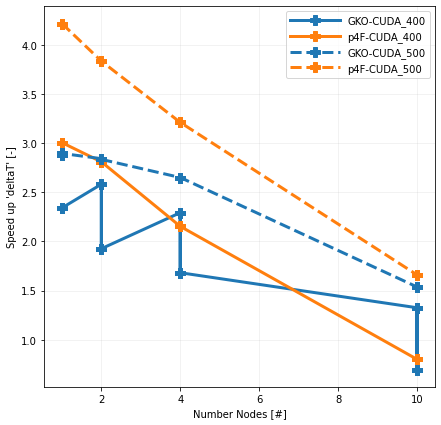

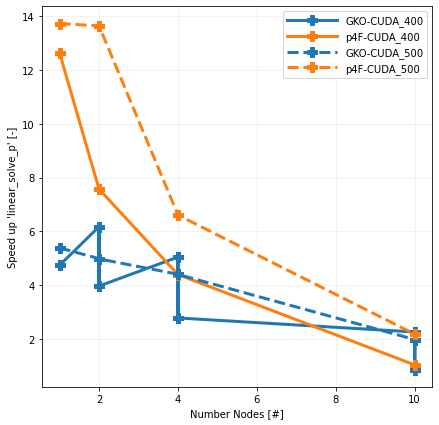

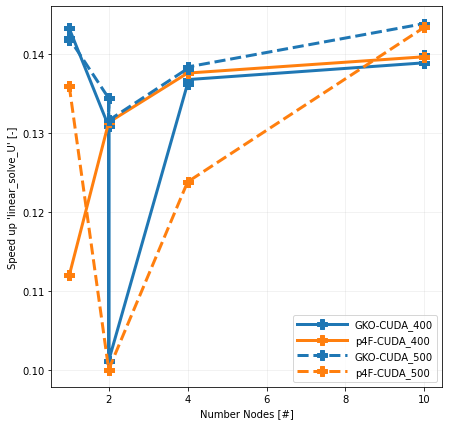

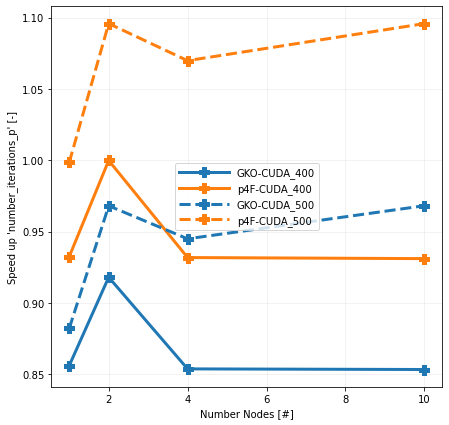

In [101]:
revision = "010a2918"
branch = "distributed-update"
case = "lidDrivenCavity"
campaign = "multi_node"
path_case = "../../results/{}/".format(branch)
path = Path("../../results/{}/".format(branch))

df = idx_query(
    import_results(
        path=path_case,
        case=case,
        campaign=campaign,
        revision=revision,
        short_hostname_map={
            "nla": "nla",
            "hkn": "horeka",
        },
        filt="matrix_format",
        transform_resolution=False
    )["raw"],
    [
        ("solver_p", "CG"),
        ("node", "horeka", True),
        ("resolution", 300, False)
    ])


df = pd.concat([idx_query(df, [("backend_p", backend)]) for backend in ["Ginkgo", "PETSC", "OpenFOAM" ]])

df = calc_nodes(df, "executor_p", [["CUDA", 4], ["Default", 76]])
e = df.index.get_level_values("executor_p")
b = df.index.get_level_values("backend_p")
df.index = df.index.droplevel("backend_p")
m = {"CUDAGinkgo": "GKO-CUDA", "CUDAPETSC": "p4F-CUDA", "DefaultPETSC":"p4F-Default", "DefaultOpenFOAM": "OF"}
merged = [m[a+b] for a,b in zip(e,b)]
df["backend_p"] = merged
df.set_index("backend_p",append=True, inplace=True)

ogl_plot(
    df,
    ys=["deltaT", "linear_solve_p", "linear_solve_U", "number_iterations_p"],
    x="nodes",
    x_label = "Number Nodes [#]",
    idxs = [],
    host="HoreKa",
    case=case,
    campaign=campaign,
    facet_is_legend="add",
    facets = ["backend_p", "resolution"],
    speedup_base = [("backend_p", "OF")])

In [58]:
df = import_results(
    path=path_case,
    case=case,
    campaign=campaign,
    revision=revision,
    short_hostname_map={
        "nla": "nla",
        "hkn": "horeka",
    },
    filt="matrix_format",
    transform_resolution=False
    )["raw"]


importing Logs ../../results/distributed-update/010a2918/lidDrivenCavity/multi_node/Logs


importing Logs ../../results/distributed-update/010a2918/lidDrivenCavity/oversubscribe/Logs
save  HoreKa_oversubscribe_Speed_up_deltaT_over_4_by_mpi_ranks_rev_010a2918_.png
save  HoreKa_oversubscribe_Speed_up_linear_solve_p_over_4_by_mpi_ranks_rev_010a2918_.png
save  HoreKa_oversubscribe_Speed_up_linear_solve_U_over_4_by_mpi_ranks_rev_010a2918_.png
save  HoreKa_oversubscribe_Speed_up_number_iterations_p_over_4_by_mpi_ranks_rev_010a2918_.png


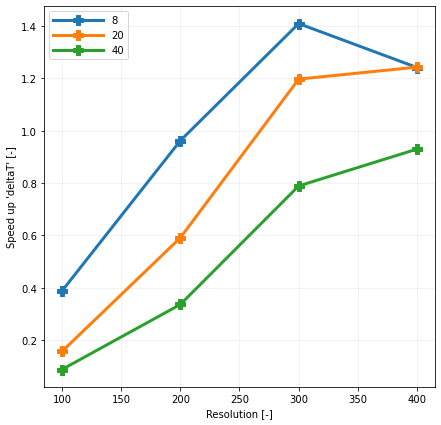

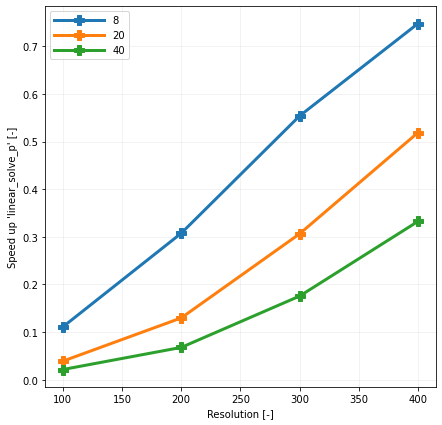

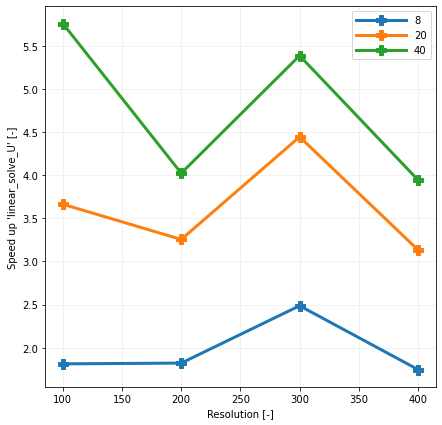

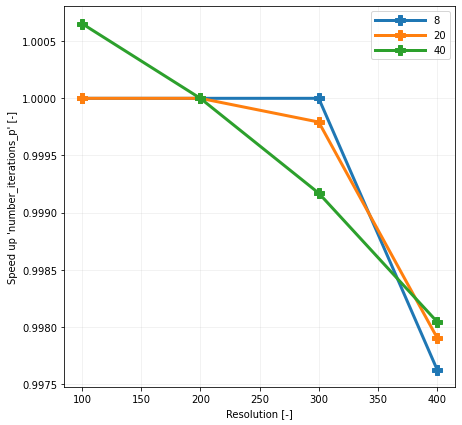

In [116]:
revision = "010a2918"
branch = "distributed-update"
case = "lidDrivenCavity"
campaign = "oversubscribe"
path_case = "../../results/{}/".format(branch)
path = Path("../../results/{}/".format(branch))


df = idx_query(
    import_results(
        path=path_case,
        case=case,
        campaign=campaign,
        revision=revision,
        short_hostname_map={
            "nla": "nla",
            "hkn": "horeka",
        },
        filt="matrix_format",
        transform_resolution=False
    )["raw"],
    [
        ("solver_p", "CG"),
        ("node", "horeka", True),
        ("mpi_ranks",0,False),
        ("backend_p", "OpenFOAM",False),
    ])

df_4 = idx_query(df, [("backend_p", "Ginkgo"),("mpi_ranks", 4),])

m = {
    "CUDAGinkgo": "GKO-CUDA", 
    "CUDAPETSC": "p4F-CUDA", 
    "DefaultPETSC":"p4F-Default", 
    "DefaultOpenFOAM": "OF"}
df = merge_index(df, "backend_p", "executor_p", m)

ogl_plot(
    df,
    ys=["deltaT", "linear_solve_p", "linear_solve_U", "number_iterations_p"],
    x="resolution",
    x_label="Resolution [-]",
    idxs = [],
    host="HoreKa",
    campaign=campaign,
    case=case,
    facets = ["mpi_ranks"],
    speedup_base = [("mpi_ranks", 4)])

importing Logs ../../results/distributed-update/010a2918/lidDrivenCavity/repartition/Logs
save  HoreKa_repartition_Speed_up_deltaT_over_4_by_mpi_ranks_rev_010a2918_.png
save  HoreKa_repartition_Speed_up_linear_solve_p_over_4_by_mpi_ranks_rev_010a2918_.png
save  HoreKa_repartition_Speed_up_linear_solve_U_over_4_by_mpi_ranks_rev_010a2918_.png
save  HoreKa_repartition_Speed_up_number_iterations_p_over_4_by_mpi_ranks_rev_010a2918_.png


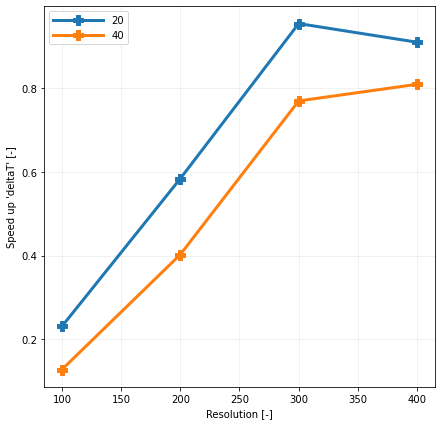

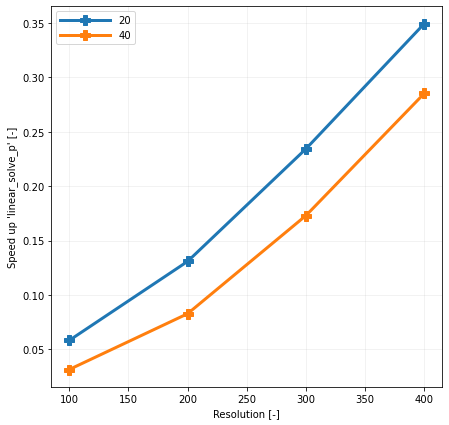

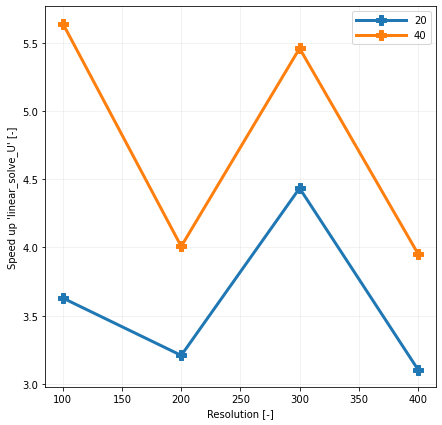

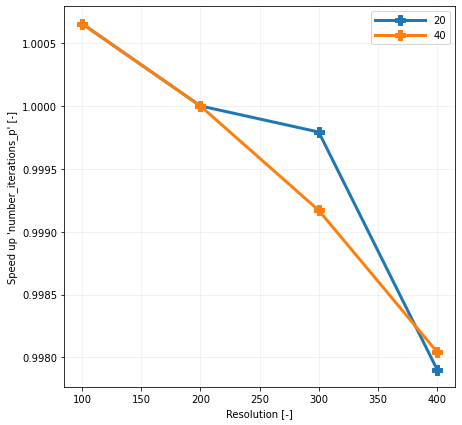

In [117]:
revision = "010a2918"
branch = "distributed-update"
case = "lidDrivenCavity"
campaign = "repartition"
path_case = "../../results/{}/".format(branch)
path = Path("../../results/{}/".format(branch))

df = idx_query(
    import_results(
        path=path_case,
        case=case,
        campaign=campaign,
        revision=revision,
        short_hostname_map={
            "nla": "nla",
            "hkn": "horeka",
        },
        filt="matrix_format",
        transform_resolution=False
    )["raw"],
    [
        ("solver_p", "CG"),
        ("node", "horeka", True),
        ("mpi_ranks", 0, False),
        ("mpi_ranks", 4, False),
    ])

df_40 = df
df_4.index = df_4.index.droplevel("mpiRank_of")
df_40 = df_40.reorder_levels(df_4.index.names,)
df=pd.concat([df_40, df_4])
m = {
    "CUDA1": "GKO-CUDA", 
    "CUDAGinkgo": "GKO_CUDA",
    "DefaultPETSC":"p4F-Default", 
    "DefaultOpenFOAM": "OF"}

#df = merge_index(df, "backend_p", "executor_p", m)

ogl_plot(
    df,
    ys=["deltaT", "linear_solve_p", "linear_solve_U", "number_iterations_p"],
    x="resolution",
    x_label="Resolution [-]",
    idxs = [],
    host="HoreKa",
    case=case,
    campaign=campaign,
    facets = ["mpi_ranks"],
    speedup_base = [("mpi_ranks", 4)])

In [111]:
df

timestamp  \
executor_p backend solver_p preconditioner_p resolution omp_threads mpi_ranks node   backend_p mpiRank_gko processes                               
CUDA       0       CG       NoPrecond        400        1           40        horeka Ginkgo    1           1          2022-10-10 09:13:45.564771   
                                                                    20        horeka Ginkgo    1           1          2022-10-10 09:13:45.590492   
                                             300        1           40        horeka Ginkgo    1           1          2022-10-10 09:13:45.655280   
                                                                    20        horeka Ginkgo    1           1          2022-10-10 09:13:45.678068   
                                             200        1           40        horeka Ginkgo    1           1          2022-10-10 09:13:45.703399   
                                                                    20        horeka Ginkgo    1           1          2022-10-10 09:13:45.723007   
                                             100        1           40        horeka Ginkgo    1           1          2022-10-10 09:13:45.760098   
                                                                    20        horeka Ginkgo    1           1          2022-10-10 09:13:45.785578   
                                             400        1           4         horeka Ginkgo    1           1          2022-10-10 09:10:18.980816   
                                             300        1           4         horeka Ginkgo    1           1          2022-10-10 09:10:19.027336   
                                             200        1           4         horeka Ginkgo    1           1          2022-10-10 09:10:19.068822   
                                             100        1           4         horeka Ginkgo    1           1          2022-10-10 09:10:19.108615   

                                                                                                                                                log_id  \
executor_p backend solver_p preconditioner_p resolution omp_threads mpi_ranks node   backend_p mpiRank_gko processes                                     
CUDA       0       CG       NoPrecond        400        1           40        horeka Ginkgo    1           1          70be8727603c544024648d4fa89449c7   
                                                                    20        horeka Ginkgo    1           1          32f94b282ae2d9f644b4a4332f9575f0   
                                             300        1           40        horeka Ginkgo    1           1          0735fe47a036726a1c3023d6be51ff33   
                                                                    20        horeka Ginkgo    1           1          f456256044a6603e0b02ca46ee042806   
                                             200        1           40        horeka Ginkgo    1           1          bee40ad8044d4c7fbb20ed1d1bc06bb0   
                                                                    20        horeka Ginkgo    1           1          6518a7807b7d17879335345a4453e2b7   
                                             100        1           40        horeka Ginkgo    1           1          16a5ec8ea8a9a3c5b8dbc372c515ade8   
                                                                    20        horeka Ginkgo    1           1          c38020b7ad4cfa9605b4e4d0ba9de97e   
                                             400        1           4         horeka Ginkgo    1           1          b754f742bd5054377b92c15bd828d34a   
                                             300        1           4         horeka Ginkgo    1           1          600bc0e5b414a995b41d73636bc8f45b   
                                             200        1           4         horeka Ginkgo    1           1          e27e6711cfcd320b48dd117fce478eab   
                                             100        1   

Breakdown_linear_solve_p_over_mpi_ranks_at_400.png


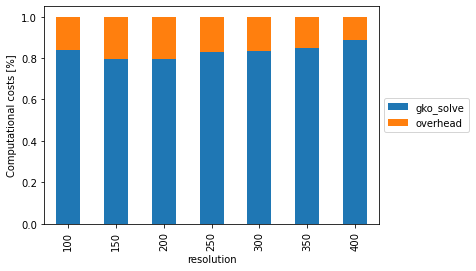

In [88]:
#resolution = 400
#df["linear_solve_p"] = df["linear_solve_p"]/1000
sel = idx_query(df, [("backend_p", "GKO-CUDA")])
a = ["linear_solve_p"]
c = ['gko_solve'] 
sel = sel[c + a]
#over = "mpi_ranks"
sel = idx_keep_only(sel, ["resolution"])

sel["overhead"] = sel[a]
for i in c:
    sel["overhead"] = (sel["overhead"] - sel[i])

sel["gko_solve"] = sel["gko_solve"]/sel["linear_solve_p"]
sel["overhead"] = sel["overhead"]/sel["linear_solve_p"]

sel = sel[c + ["overhead"]]

plot = sel.sort_index().plot.bar(stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plot.set_ylabel("Computational costs [%]")
fn = "Breakdown_{}_over_{}_at_{}.png".format(a[0],over,resolution)
print(fn)
plt.savefig(path / fn   , bbox_inches='tight')

In [80]:
sel["other"]

resolution
400    944.505132
300    412.569684
200    111.914842
150     43.353737
100     13.764579
350    663.389658
250    209.964895
Name: other, dtype: float64

ConsumedEnergy_multinode.png


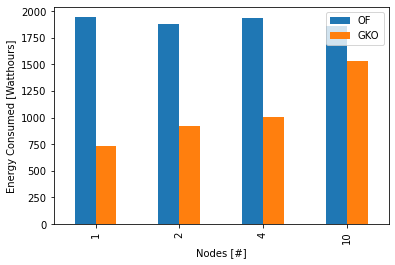

In [130]:
power_draw = {"OF":[1944, 1880, 1935, 1860], "GKO":[735, 920, 1002, 1534]}#, "Nodes": [1,2,4,10]}
df = pd.DataFrame(power_draw, index=[1,2,4,10])

df.plot(kind="bar", ylabel="Energy Consumed [Watthours]",xlabel="Nodes [#]")
fn = "ConsumedEnergy_multinode.png"
print(fn)
plt.savefig(path / fn   , bbox_inches='tight')